# Movie Recommendation using the Wikipedia Movie Plot Summary Dataset

John Philip<br>
Prof. Kathleen Durant<br>
DS4100: Data Collection, Integration and Analysis<br>
7 December 2018

## Part 1: Augmenting The Wikipedia Plot Summary Dataset (Collecting Data)

We start off the data collection and cleaning pipeline with two datasets from Wikipedia. In order to wrangle this data, I decided to use Python, more specificially, the CSV and Pandas modules.

In [1]:
import pandas as pd
import csv
import os
import datetime
import requests
import sqlite3
import numpy as np
import statistics
from scipy import spatial
from time import sleep
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
%matplotlib inline

Since a lot of the data was missing from the Wikipedia dataset, I decided to augment this dataset with more data from the OMDB API.

In [2]:
API_URL = "http://www.omdbapi.com"
API_KEY = "d8a2854c"

This simple utility function makes the request to the OMDB API and returns the data in JSON format. 

In [3]:
def ping_api(movie_name, year=None, api_key=API_KEY):

    request_params = {'apikey': api_key, 'type': 'movie', 't': movie_name, 'plot': 'full'}

    # If the year is provided, use it to narrow down the approach.
    if year:
        request_params['y'] = year

    r = requests.get(API_URL, params=request_params)

    return r.json()

I read in the dataframes and concatenate them into one big dataframe, so that we can iterate over it using the CSV module.

In [4]:
# Concatenate the dataframes into one big dataset.
df = pd.concat([pd.read_csv("datasets/wiki_dataset_1.csv", index_col=0),
                pd.read_csv("datasets/wiki_dataset_2.csv", index_col=0)], ignore_index=True)

# Create a CSV that I can use to read the data.
df.to_csv("intermediate.csv")

imputation_targets = ("Unknown", "N/A", "unknown", "")

## Imputation Pipeline (Collecting Data)

1. Open the concatenated dataframe, as well as the final CSV we will need to write to.
2. Add the columns for the supplementary data.
3. Query the API with the title of the movie found in each row, and if possible, the year it was produced.
4. If the movie wasn't found on the database, continue with the next row.
5. If we've reached the request limit on this API key, then sleep for 24 hours and continue the cycle.
6. At this point, we have a valid JSON response from the API, so impute the fields with whatever it returns, and add the additional data to the appropriate columns.
7. If there are any issues with any particular row, then continue with the next row. 

In [ ]:
# Imputes missing data from the wikipedia plot summary dataset with OMDB-scraped data, and supplements it with
# extra data.
# Just in case this gets run again, write all of this to final_copy.csv.
with open("intermediate.csv") as read_file, open("final_copy.csv", 'a') as write_file:

    reader = csv.DictReader(read_file)

    supplementary_data = ["Runtime", "imdbRating", "imdbVotes", "Rated", "Rotten Tomatoes", "Metacritic"]

    writer = csv.DictWriter(write_file, fieldnames=df.columns.tolist() + supplementary_data)
    writer.writeheader()
    movie_json = {}

    for row in reader:

        row = dict(row)

        try:
            # Ping the API
            movie_json = ping_api(row["Title"],
                                  year=row["Release Year"] if row["Release Year"] not in imputation_targets else None,
                                  api_key=API_KEY)

            # If the movie doesn't exist in the OMDB database, then skip this row, since we can't add any extra data
            # to it.
            if movie_json["Response"] == "False":
                
                # Repeat the queries
                if movie_json["Error"] == "Request limit reached!":
                    print("Timed out: JSON response is: {}".format(movie_json))
                    
                    # There's a 1 day timeout limit, so repeat this part of the pipeline tomorrow
                    sleep(3600 * 24)

                elif movie_json["Error"] == "Movie not found!":
                    print("Not found: JSON response is: {}".format(movie_json))

                print("Empty API response for {}. ".format(row["Title"]))

                continue

            print("{}:\t\tImputing data for {}.".format(str(datetime.datetime.now()), row["Title"]))

            # If any of these fields are imputable, impute them.
            if row["Director"] in imputation_targets:
                row["Director"] = movie_json["Director"] if movie_json["Director"] != "N/A" else ""

            if row["Release Year"] in imputation_targets:
                row["Release Year"] = movie_json["Year"]

            if row["Genre"] in imputation_targets:
                row["Genre"] = movie_json["Genre"]

            if row["Cast"] in imputation_targets:
                row["Cast"] = movie_json["Actors"] if movie_json["Actors"] != "N/A" else ""

            if row["Plot"] in imputation_targets:
                row["Plot"] = movie_json["Plot"]

            # Supplement with additional data
            row["imdbRating"] = movie_json["imdbRating"] if movie_json["imdbRating"] != "N/A" else ""
            row["imdbVotes"] = movie_json["imdbVotes"] if movie_json["imdbVotes"] != "N/A" else ""
            row["Rated"] = movie_json["Rated"] if movie_json["Rated"] not in ("N/A", "NOT RATED", "PASSED", "UNRATED", "APPROVED") else ""

            # Go through the ratings list, and add the appropriate fields.
            if "Ratings" in movie_json:
                for rating in movie_json["Ratings"]:
                    row[rating["Source"]] = rating["Value"] if rating["Source"] in supplementary_data else ""

            writer.writerow({key: val for key, val in row.items() if key != ""})

        except KeyError as e:
            
            print("Movie JSON: {}".format(movie_json))
            print("Row: {}".format(row) + "\n")
            print("{}:\t\tRan into a key error for row {}.".format(str(datetime.datetime.now()), row["Title"]))

        except (KeyboardInterrupt, Exception) as e:
            
            # Write the files we have so far just in case something comes up during the execution of this portion.
            print("Writing files ...")
            break

After imputing the missing data, and augmenting the dataset with the Rotten Tomatoes and Metacritic data, write it out to a CSV file, and split it back up. I split up the data because my computer doesn't allow me to open incredibly large files, so I look at each one separately.

In [5]:
df = pd.read_csv("final.csv", index_col=0)

# Write out the new dataframe to two CSVs.
df[:int(len(df) / 2)].to_csv("souped_up_movie_dataset_1.csv")

df[int(len(df) / 2):].to_csv("souped_up_movie_dataset_2.csv")

if os.path.isfile("intermediate.csv"):
    os.remove("intermediate.csv")

## Database Population (Data Shaping)

Here, we are going to take the augmented dataset that we created in the previous section of this notebook, and store it in a relational database. We put the database in 3rd normal form, in order to reduce redundancy, and enhance data integrity. We use the sqlite3 Python package, which allows for lightweight and in-memory relational database creation, which is the most natural form for this database to take.

Since we are in the process of writing the database, we can create a virtual connection to an in-memory database, and then dump out the contents of the database to a file later.

In [6]:
# Connect to the database
conn = sqlite3.connect(':memory:')

The following cells will just be some utility functions that allow us to more easily add rows into our database later.

In [7]:
def query_for_join_table(type, movie_id, val_id):
    
    # Returns the appropriately formatted query for populating the join tables between movies and other tables.
    return """
           insert into movie_has_{0} (movie_id, {0}_id) values ({1}, {2})
           """.format(type, movie_id, val_id)

In [8]:
def query(query_string, conn=conn):
    
    # Returns the results of a particular SQL query.
    cur = conn.cursor()
    cur.execute(query_string)

    return cur.fetchall()

In [9]:
def id_from_name(name, table):
    
    # Return the id associated with a particular name from a particular table.
    return query('select {0}_id from {0} where name="{1}"'.format(table, name.strip().title()))

In [10]:
def add_name_to_table(name, table):
    
    # Insert the given name into the given table, and for convenience, return the id associated with the newly created name.
    query('insert into {0} (name) values ("{1}")'.format(table, name.strip().title()))

    return id_from_name(name, table)

In [11]:
def get_id(val, table):
    
    # If the value isn't in the table, add it, and then return the ID associated with it.
    val = val.lower().title()
    
    ids = id_from_name(val, table)

    if len(ids) == 0:

        # Val doesn't exist yet, so insert them, then get back their id
        ids = add_name_to_table(val, table)

    # We should now be guaranteed to have one entry in ids
    assert len(ids) == 1

    return int(ids[0][0])

In order to set up the database, we declare the schema of the database in the movie.sql file. Running that script populates the database with the appropriate tables that we can then insert into as we iterate through the dataset.

In [12]:
# Setting up the main database, loading in the table schema
with open("movie.sql") as f:
    script = f.read()

cur = conn.cursor()
cur.executescript(script)

Running the cell below will allow you to see the movie.sql file contents, which contain our entire database schema.

In [13]:
%pycat movie.sql

## Insertion Process (Data Shaping)
1. First, read the CSV into a pandas dataframe.
2. Second, replace all of the NaNs with empty strings.
3. Since the index of each row is unique, we can use that to represent each movie_id in the database.
4. Strip all of the appropriate fields of whitespace, canonicalize them by titling them, and then format the query appropriately.
5. For each of the fields that can have multiple values per row, independently insert each of the values into the correct table and its corresponding join table.
6. Since each of the ratings (metacritic, rotten tomatoes, and IMDB) are on different scales, normalize them before we enter them into the database.

In [ ]:
# Start reading through the big CSV
df = pd.read_csv("final.csv")

for index, row in df.iterrows():

    row = {key: (str(val).replace('"', '') if str(val) != "nan" else "") for key, val in dict(row).items()}

    movie_id = index + 1

    try:
        
        # Attempt to insert a movie into the database, and canonicalize and normalize the fields.
        INSERT_MOVIE_QUERY = 'insert into movie (movie_id, origin, year, title, wiki_link, plot, imdb_rating, imdb_votes, rated, rotten_tomato_rating, metacritic_rating) values ({}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {})'.format(movie_id,
                                       '"{}"'.format(row["Origin/Ethnicity"].strip().title()) if row["Origin/Ethnicity"] else "NULL",
                                       int(row["Release Year"]) if row["Release Year"] else "NULL",
                                       '"{}"'.format(row["Title"].strip().title()) if row["Title"] else "NULL",
                                       '"{}"'.format(row["Wiki Page"]) if row["Wiki Page"] else "NULL",
                                       '"{}"'.format(row["Plot"].strip().capitalize()) if row["Plot"] else "NULL",
                                       float(row["imdbRating"]) / 10 if row["imdbRating"] else "NULL",
                                       row["imdbVotes"].replace(",", "") if row["imdbVotes"] else "NULL",
                                       '"{}"'.format(row["Rated"].strip()) if row["Rated"] else "NULL",
                                       int(row["Rotten Tomatoes"]) / 100 if row["Rotten Tomatoes"] else "NULL",
                                       int(row["Metacritic"]) / 100 if row["Metacritic"] else "NULL")
    except ValueError as e:

        # There is a strange row in the dataset that just has the header names repeated again. If we run into this,
        # then move onto the next row. If that isn't the problem, then raise the exception again.
        if row["Release Year"] == "Release Year":
            continue
        else:
            raise e

    query(INSERT_MOVIE_QUERY)
    
    for label, table in [("Director", "director"), ("Cast", "actor"), ("Genre", "genre")]:
        
        # If there are values for this label,
        if row[label]:
            
            # Get a list of all of these values
            val_list = row[label].strip().split(',')
            for val in val_list:
                
                # If each value in the list is not "",
                if val:
                    
                    # Add it to the appropriate table.
                    query(query_for_join_table(table, movie_id, get_id(val, table)))

Our database now holds all of the relevant data from the CSVs, so we can dump it out to a SQL file that we can later reload into memory.

In [14]:
# Just in case this gets run again, write it to copy of dump.sql
with open('dump_copy.sql', 'w') as f:
    
    # Go through each definition and write it to a file.
    for line in conn.iterdump():
        f.write('%s\n' % line)

## Data Retrieval (Exploring Data Through Visualization)

In this portion of the pipeline, we're going to selectively retrieve a portion of the data that is clean, and can be used to make significant recommendations to users.

First, we're going to load in the database that we populated in the previous section of the notebook, which contains the dataset in fully normalized form. 

In [15]:
conn = sqlite3.connect(":memory:")

with open("dump.sql") as f:
    script = f.read()

# Execute the database creation script.
cur = conn.cursor()
cur.executescript(script)

In [16]:
def query(query_string, conn=conn):

    cur = conn.cursor()
    cur.execute(query_string)
    
    res = cur.fetchall()
    
    # Cleanly format the responses
    if len(res) > 0:
        
        if len(res[0]) == 1:
            return [x[0] for x in res]
        else:
            return [list(x) for x in res]
        
    return []

Just to get a better idea of what data we're working with, we're going to do some exploratory analysis to gain some insights about our dataset.

0.36611326817512385


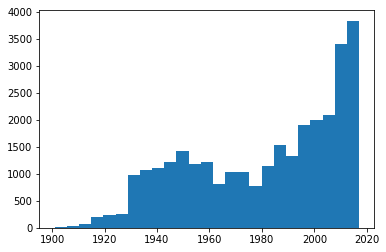

In [17]:
years = query("SELECT year FROM movie")

plt.hist(years, bins=25)
perc_after_1977 = len([year for year in years if year >= 2000]) / len(years)
print(perc_after_1977)

From this histogram, we can see that the majority of the data falls within the last ~40 years, with 36.6% of movies before produced after 2000. The jump in the 1920s was actually as a result of the release of the first sound film created, The Jazz Singer, and the very inspiring effect it had on the movie industry. As movie techniques got more advanced, different genres of film gained more popularity, and expanded the movie space. These are good things to keep in 

In [18]:
# Counts up all of the non-null ratings of a particular type for movies and displays their counts year by year
def visualize_ratings(rating):
    
    year_ratings = [list(x) for x in query("SELECT year, {} FROM movie".format(rating))]
    ratings = {}

    for x in year_ratings:

        if x[1] is not None:
            if x[0] not in ratings:
                ratings[x[0]] = 1
            else:
                ratings[x[0]] += 1

    ratings = [[x, ratings[x]] for x in sorted(ratings.keys())]
    years = [x[0] for x in ratings]
    ratings = [x[1] for x in ratings]
    plt.scatter(years, ratings)
    plt.show()

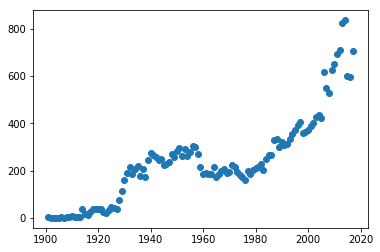

In [19]:
visualize_ratings("imdb_rating")

From this snippet, we can see that the amount of movies that actually have IMDB ratings is relatively low, and in order to make intelligent judgements about recommendations, we want to include movies that have relatively solid IMDB ratings. Let's see if the same trend exists for the metacritic and rotten tomatoes data.

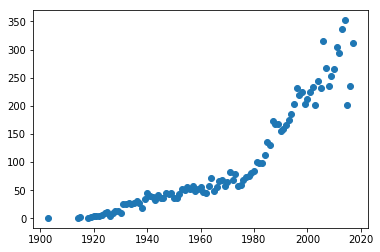

In [20]:
visualize_ratings("rotten_tomato_rating")

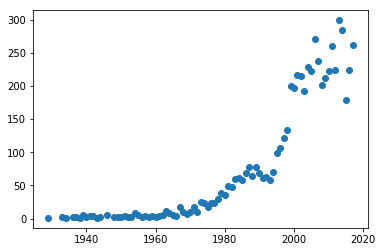

In [21]:
visualize_ratings("metacritic_rating")

## Findings (Mining Data For Insights)

The same trends in ratings do seem to exist among the different sources of ratings. This supports the decision to probably limit the scope of movies we recommend to those released post, say, 2000. Given that there is minimal training data for movies before this period in terms of ratings, our model would be extrapolating from a region with little to no data, which does not yield very reliable results.

## Creating / Cleaning Dataset (Mining Data For Insights)

There exist a lot of composite genres in the tables that we created out of the original dataset, ex) Comedic Romance, or Action Horror. Instead of creating dummy codes for each one of these categorical genres, we can create joint dummy codes that more accurately represent the overall genre of a movie. This will give us a more general vector that will allow our recommendation system to generalize more effectively.

For example: 

###### Romantic Comedy

| Romance  | Comedy  | Action  |  Sci-Fi |
|---|---|---|---|
|  1 | 1  |  0 | 0  |


###### Action Romance

| Romance  | Comedy  | Action  |  Sci-Fi |
|---|---|---|---|
|  1 | 0  |  1 | 0  |
   
   
First, we should determine which of the broadest categories we should cater to in order to not pigeonhole our recommendations to rather esoteric genres.

In [22]:
# Get all genre names from movies released from 2000 onward.
names = query("""
            SELECT genre.name
            FROM movie
            JOIN movie_has_genre ON (movie_has_genre.movie_id = movie.movie_id)
            JOIN genre ON (movie_has_genre.genre_id = genre.genre_id)
            WHERE year >= 2000
            GROUP BY genre.name
            """)

We need to be able to expand the genre lists that these genres come in. We split up by common delimiters, and add them to a big list in order to analyze their frequency.

In [23]:
# Split up the genre names by popular delimiters
char_list = (" - ", " & ", " / ", "-", "/", "&")
result = []
for name in names:
    for delim in char_list:
        if delim in name:
            for genre in name.split(delim):
                result.append(genre.strip())
            break
        elif (delim == char_list[-1]):
            result.append(name)

<BarContainer object of 27 artists>

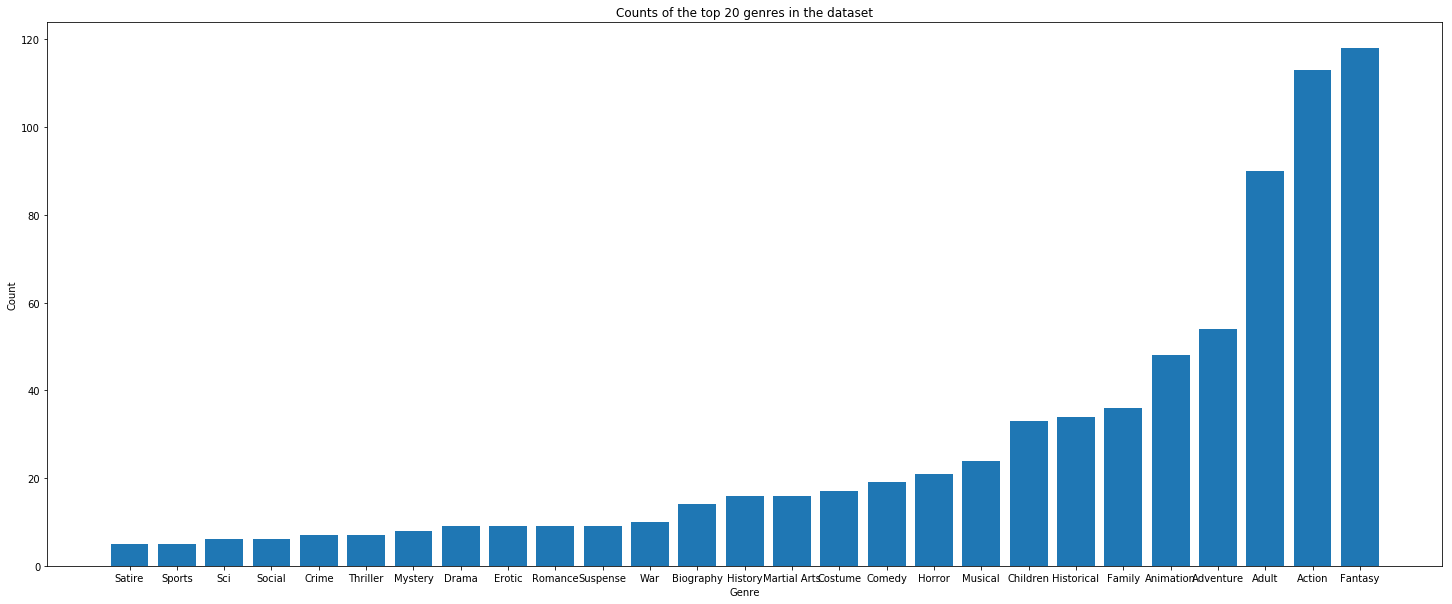

In [24]:
# Get the counts of each genre and convert the counts to a dictionary
def list_to_dict(input_list):
    
    result = {}
    for x in input_list:
        if x in result:
            result[x] += 1
        else:
            result[x] = 1
            
    return result

# Filter out the genres that don't show up in the top k categories
def top_k_categories(input_dict, k):
    
    return {word: freq for word, freq in input_dict.items() if freq in sorted(set(input_dict.values()))[-k:]}
    
categories = top_k_categories(list_to_dict(result), 20)

keys = sorted(categories.keys())
vals = [categories[x] for x in categories]

genres = []
hits = []

# Sort all of the genres by the amount of hits they received.
for key, val in sorted(zip(keys, vals), key=lambda x: x[1]):
    genres.append(key)
    hits.append(val)

# Plot the genres versus hits
plt.figure(figsize=(25,10))
plt.title("Counts of the top 20 genres in the dataset")
plt.ylabel("Count")
plt.xlabel("Genre")
plt.bar(genres, hits)

In order to make our recommendations more robust, we would like to eliminate the outlier genres. We can define the outlier genres to be those that we can cut off while maintaining at least 80% of our genre data. Knowing that 80% of the total data falls within at least one of these genres, the accuracy of this model has a higher probability of being better, since it aims to predict based on a smaller amount of dimensions, but ones that we have more data about. If we were given more volume of data to work with that had a lot of genre hits for smaller categories, then our model could perform better, and could be incorporated in the future.

In [25]:
# Keep all of the genres that keep the percentage under the threshold.
total = sum(hits)
perc = 0
GENRE_HIT_THRESHOLD = 0.80
genres_post_filtering = []

# Reverse the genres and hits
for genre, hit in zip(list(reversed(genres)), list(reversed(hits))):
    if (perc < GENRE_HIT_THRESHOLD):
        perc += hit / total
        genres_post_filtering.append(genre)
    else:
        break

In order to actually get decent recommendations, let's only use the movies with ratings > 0.5 across the board.

In [26]:
learning_dataset = query("""
                        SELECT movie.movie_id, group_concat(genre.name), imdb_rating, metacritic_rating, rotten_tomato_rating 
                        FROM movie
                        JOIN movie_has_genre ON (movie.movie_id = movie_has_genre.movie_id)
                        JOIN genre ON (genre.genre_id = movie_has_genre.genre_id)
                        WHERE year >= 2000
                        AND imdb_rating > 0.5
                        AND metacritic_rating > 0.5
                        AND rotten_tomato_rating > 0.5
                        GROUP BY movie.movie_id, imdb_rating, metacritic_rating, rotten_tomato_rating
                        """)
len(learning_dataset)

2015

Now let's expand out the dataset to create the dummy codes for the categorical genre data.

In [27]:
col_list = ["movie_id"] + genres_post_filtering + ["imdb_rating", "metacritic_rating", "rotten_tomato_rating"]
df = pd.DataFrame(None, columns=col_list)

In [28]:
df

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating


In [29]:
df_list = [df]

for row in learning_dataset:
    
    expanded_list = []
    
    for idx, elem in enumerate(row):
        
        if idx != 1:
            expanded_list.append(elem)
        else:
            for genre in genres_post_filtering:
                expanded_list.append(int(genre.lower() in elem.lower()))
    
    df_list.append(pd.DataFrame({key: [val] for key, val in zip(col_list, expanded_list)}))
    
df = pd.concat(df_list, ignore_index=True)

In [30]:
df.head()

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating
0,12882,0,0,0,0,0,0,0,0,0,0,1,0,0.79,0.90,0.89
1,12883,0,0,0,0,0,0,0,0,0,0,1,0,0.76,0.64,0.68
2,12884,0,0,0,0,0,0,0,0,0,0,0,0,0.66,0.65,0.82
3,12895,0,0,0,0,0,0,0,0,0,0,0,0,0.73,0.85,0.73
4,12896,0,0,0,0,0,0,0,0,0,0,0,0,0.75,0.78,0.94


Since this is purely unlabeled data, we can employ a semi-supervised approach to finding out which movies are "closest" to each other, and recommend based on the clusters that were found.

In [31]:
X = df.as_matrix(genres_post_filtering + ["imdb_rating", "metacritic_rating", "rotten_tomato_rating"])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [32]:
from sklearn.cluster import MeanShift

ms = MeanShift()
ms.fit(X)

# After fitting the data, we can see how many clusters we obtained after fitting the model.
labels = ms.labels_
num_clusters = len(np.unique(labels))
print(num_clusters)

60


This vector is close to the other vectors in cluster 1, so that's what this should predict.

In [33]:
ms.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0.79, 0.90, 0.89]])[0]

1

According to to the clustering algorithm, there were about 60 clusters that most accurately characterized the dataset.

In [34]:
print(num_clusters)

60


## Evaluating the Model

Since this is unlabeled data, we don't have ground truth to evaluate a concrete metric. However, we can use cosine similarity to evaluate whether or not a vector's average deviation from the entire dataset is smaller than that of it's cluster. While this isn't a perfect way to evaluate model performance, this naive approach proves that it's associating movies together non-arbitrarily.

In [35]:
df["pred_labels"] = labels

In [36]:
df.head()

,movie_id,Fantasy,Action,Adult,Adventure,Animation,Family,Historical,Children,Musical,Horror,Comedy,Costume,imdb_rating,metacritic_rating,rotten_tomato_rating,pred_labels
0,12882,0,0,0,0,0,0,0,0,0,0,1,0,0.79,0.90,0.89,1
1,12883,0,0,0,0,0,0,0,0,0,0,1,0,0.76,0.64,0.68,1
2,12884,0,0,0,0,0,0,0,0,0,0,0,0,0.66,0.65,0.82,0
3,12895,0,0,0,0,0,0,0,0,0,0,0,0,0.73,0.85,0.73,0
4,12896,0,0,0,0,0,0,0,0,0,0,0,0,0.75,0.78,0.94,0


In [37]:
def similarity(vector1, vector2):
    return 1 - spatial.distance.cosine(vector1, vector2)

# Prediction

Given a vector representing a movie, we want to recommend some other movies to the user. We can do this via a k-means clustering algorithm, and then doing a k-nearest neighbors lookup in that cluster.

1. First, isolate the cluster that this vector belongs to.
2. Filter out all of the other vectors that don't belong to that cluster.
3. Find the cosine similarity between all of those vectors and the given vector.
4. Sort the movie ids and similarities in descending order, and then just pick off the num_preds first tuples.
5. Lookup the movie_id in order to return the title and release year.

In [38]:
def predict(vector, num_preds):
    
    sim_and_id = []
    
    # Get the rows that are associated with this vector's predicted label
    temp_df = df[df["pred_labels"] == ms.predict([vector])[0]]
    
    # Get rid of the features not used for prediction
    temp_df = temp_df[[x for x in temp_df.columns.tolist() if x != "pred_labels"]]
    
    for index, row in temp_df.iterrows():
        
        movie_vector = [row[x] for x in temp_df.columns.tolist() if x != "movie_id"]
        
        sim_and_id.append((row["movie_id"], similarity(vector, movie_vector)))
        
    # Unpack the tuples 
    top_num_preds_movie_ids = tuple([res[0] for res in sorted(sim_and_id, key=lambda x: x[-1], reverse=True)[:num_preds]])
    
    if len(top_num_preds_movie_ids) > 0:
        return query("SELECT title, year FROM movie WHERE movie_id IN {}".format(str(top_num_preds_movie_ids)))
    else:
        return query("SELECT title, year FROM movie WHERE movie_id = {}".format(str(top_num_preds_movie_ids)))

Just as a sanity check, I make sure that a vector that I pass into the recommendation system automatically recommends itself (as it should).

In [39]:
print(predict([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0.89, 0.90, 0.89], num_preds=4))

[["The King'S Speech", 2010], ['House Of Flying Daggers', 2004], ['City Of Life And Death', 2009], ['The Sun', 2005]]


In [40]:
temp_df = df[[x for x in df.columns.tolist() if x not in ("movie_id", "pred_labels")]].sample(frac=0.5, replace=False)
copy = temp_df.copy()

all_dists = []

# Go through all of the vectors in the dataframe and compare them with every other vector in the dataframe
for indx_one, row_one in temp_df.iterrows():
    
    for indx_two, row_two in copy.iterrows():
        
        if indx_one < indx_two:
            
            sim = similarity([row_one[x] for x in temp_df.columns.tolist()],
                             [row_two[x] for x in temp_df.columns.tolist()])
            
            all_dists.append(sim)
            
# Find the mean cosine similarity between all vectors within the dataframe.
print(statistics.mean(all_dists))

0.7812791337049192


In [41]:
cluster_means = []

# For each of the clusters that we have from our model,
for cluster_num in range(1, num_clusters + 1):
    
    # Isolate the vectors associated with that cluster.
    temp_df = df[df["pred_labels"] == cluster_num]
    
    # Strip away the features that will not be used in the similarity calculation.
    temp_df = temp_df[[x for x in temp_df.columns.tolist() if x not in ("movie_id", "pred_labels")]]

    copy = temp_df.copy()

    all_dists = []
    
    # Find the cosine similarity between all pairs of vectors in the cluster.
    for indx_one, row_one in temp_df.iterrows():
        
        for indx_two, row_two in copy.iterrows():
            
            sim = similarity([row_one[x] for x in temp_df.columns.tolist()],
                             [row_two[x] for x in temp_df.columns.tolist()])
            
            all_dists.append(sim)
        
        cluster_means.append(statistics.mean(all_dists))
        
# Report the mean of all means among all clusters.
print(statistics.mean(cluster_means))

0.9937321869787549


As seen here, the average similarity between vectors in each cluster among all clusters is 99.4%, whereas the overall similarity between all vectors in our dataset is about 78.1%, which is significantly lesser, and with around 2,000 rows here, the difference is even more pronounced. This proves that there exist tightly clustered data, and that it can be used to recommend movies.